In [11]:
import graphviz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import zscore
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


### Load Processed Data

In [12]:
whole_data_df = pd.read_csv("ProcessedData/whole_data.csv")
new_dfs = [pd.read_csv("ProcessedData/readrandom.csv"), pd.read_csv("ProcessedData/readrandomwriterandom.csv"), pd.read_csv("ProcessedData/readreverse.csv"), pd.read_csv("ProcessedData/readseq.csv")]

### Features Graph

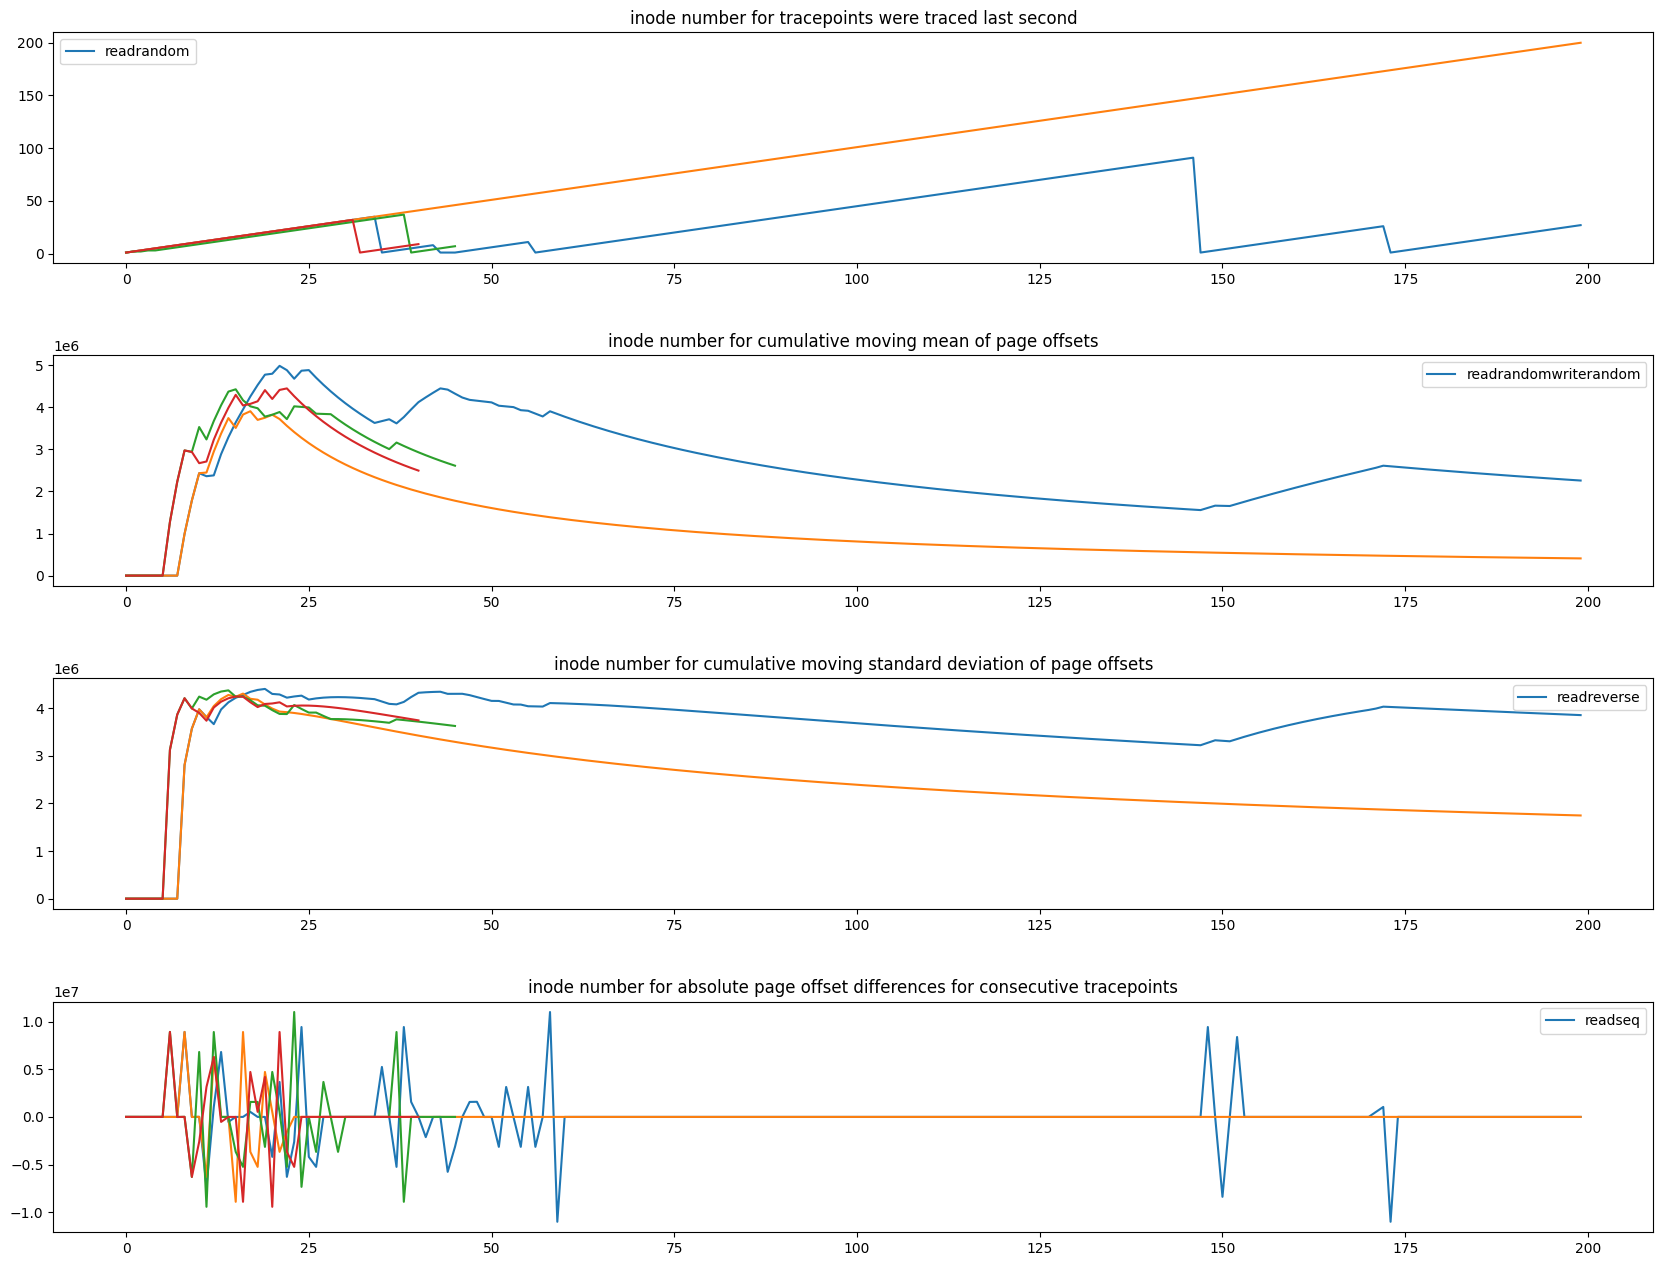

In [13]:
columns = ["workload", "tracepoints were traced last second", "cumulative moving mean of page offsets", \
    "cumulative moving standard deviation of page offsets", "absolute page offset differences for consecutive tracepoints", "inode number"]
workloads = ["readrandom", "readrandomwriterandom", "readreverse", "readseq"]

plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(4, 1, i+1)
    for df in new_dfs:
        plt.plot(df[columns[i+1]])
    plt.title("inode number for " + columns[i+1])
    plt.legend([workloads[i]])

plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()


### Standard Scaler

In [14]:
numeric_cols = whole_data_df.select_dtypes(include=[np.number]).columns
whole_data_df[numeric_cols] = whole_data_df[numeric_cols].apply(zscore)

for df in new_dfs:
    df[numeric_cols] = df[numeric_cols].apply(zscore)

display(whole_data_df)

,workload,tracepoints were traced last second,cumulative moving mean of page offsets,cumulative moving standard deviation of page offsets,absolute page offset differences for consecutive tracepoints,inode number
0,readrandom,-0.984120,-1.558945,-2.831755,-0.000002,-0.986157
1,readrandom,-0.966082,-1.558896,-2.831697,0.000050,-0.420086
2,readrandom,-0.948045,-1.558608,-2.831265,0.000437,-0.420086
3,readrandom,-0.930008,-1.558510,-2.831284,-0.000100,-0.420086
4,readrandom,-0.911971,-1.558597,-2.831285,-0.000394,-0.643382
...,...,...,...,...,...,...
482,readseq,-0.911971,0.528577,0.648304,-0.000029,-0.420086
483,readseq,-0.893934,0.473663,0.625503,-0.000043,-0.420086
484,readseq,-0.875896,0.421546,0.602582,-0.000432,-0.420087
485,readseq,-0.857859,0.372050,0.579590,0.000348,-0.420086


### Models' Data

In [15]:
X = whole_data_df.iloc[:, 1:]
y = whole_data_df["workload"]

### T-SNE Graph

(487, 5)


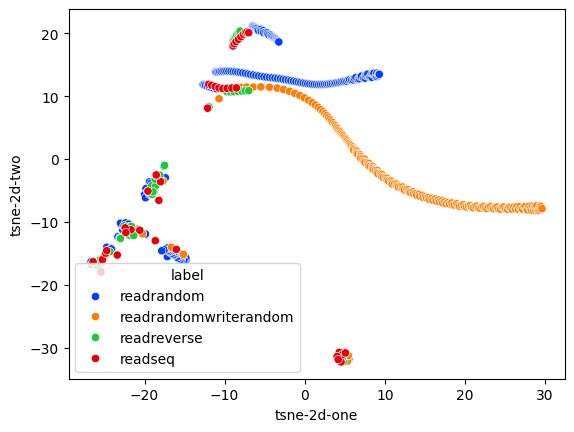

In [16]:
standardized_data = StandardScaler().fit_transform(X)
print(standardized_data.shape)
 
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("tsne-2d-one", "tsne-2d-two", "label"))
 
sn.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette="bright",
    data=tsne_df)
plt.show()

### Nueral Network Model

In [17]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### Cross-Validation

In [18]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

accuracies = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    enc = OneHotEncoder()
    enc.fit(y_train.values.reshape(-1, 1))
    y_train = pd.DataFrame(enc.transform(y_train.values.reshape(-1, 1)).toarray(), columns=enc.categories_[0])
    y_test = pd.DataFrame(enc.transform(y_test.values.reshape(-1, 1)).toarray(), columns=enc.categories_[0])
    
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)
    
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (mean_accuracy * 100, std_accuracy * 100))

Accuracy: 79.10% (+/- 5.87%)


### Decision Tree Model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 82.65%


### Decision Tree Graph

In [20]:
feature_names = X.columns
class_names = y.unique()

dot_data = export_graphviz(model, out_file=None, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("DecisionTree Graph/decision_tree", format="png", cleanup=True)
graph.render("DecisionTree Graph/decision_tree", format="pdf", cleanup=True)

'DecisionTree Graph\\decision_tree.pdf'